In [1]:
from pathlib import Path
import gc
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm, tqdm_notebook

In [2]:
DATA_PATH = Path(".") / "dataset/sentiment-analysis-on-movie-reviews"
TRAIN_DATA_PATH = DATA_PATH / 'train.tsv.zip'
TEST_DATA_PATH = DATA_PATH / 'test.tsv.zip'
GloVe_PATH = "./data/voc_1.txt"

In [3]:
pd.read_csv(TRAIN_DATA_PATH, sep="\t").sample(5)

,PhraseId,SentenceId,Phrase,Sentiment
57296,57297,2886,made it all work,3
12822,12823,552,better-focused than the incomprehensible Anne ...,2
113239,113240,6016,movie-movie,2
30302,30303,1407,last act,2
38162,38163,1814,of characters and angles,2


In [17]:
train_data = pd.read_csv(TRAIN_DATA_PATH, sep="\t")

In [18]:
test_data = pd.read_csv(TEST_DATA_PATH, sep="\t")

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import os

def draw_line_pic(x, y, x_label, y_label, title):
    plt.figure()
    plt.plot(x, y, marker='*', ms=10)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(x)

    plt.savefig(os.path.join(os.getcwd(), title), dpi=600)
def draw_lines_pic(x, y_set, x_label, y_labels, title):
    plt.figure()
    plt.xlabel(x_label)
    plt.title(title)

    for y, y_label in zip(y_set, y_labels):
        plt.plot(x, y, marker='*', linestyle='-', label=y_label)

    plt.legend()
    plt.savefig(os.path.join(os.getcwd(), title), dpi=600)

In [5]:
# draw results for each ephoch using matplotlib
def draw_result_lines(vary_set, y_set, epoch_num):

    x = [(i+1) for i in range (epoch_num)]
    x_label = 'epoch'

    y_labels = [str(item) for item in vary_set]

    title = 'Accuracy of each epoch'

    draw_lines_pic(x, y_set, x_label, y_labels, title)

### Dataset

In [83]:
# 重点分析 拆解

def GloVeEmbedding(path = GloVe_PATH, return_type='nn'):
    
    # Step 1: Parse the vocabulary and embeddings
    token2idx = {}
    embeddings = []
    with open(path,'rt') as fi:
        full_content = fi.read().strip().split('\n')
    for i in range(0,len(full_content)):
        i_word = full_content[i].split(' ')[0]
        i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
        
        token2idx[i_word] = i
        embeddings.append(i_embeddings)

    # Step 2: Add the padding and unknown tokens to the vocab and embeddings arrays
    embs_npa = np.array(embeddings)
    
    token2idx['<pad>'] = max(token2idx.values())+1    # insert <pad> in vocab
    token2idx['<unk>'] = max(token2idx.values())+1    # insert <unk> in vocab
    print(embs_npa.shape)
    pad_emb_npa = np.zeros((1,embs_npa.shape[1]))            # embedding for '<pad>' token
    unk_emb_npa = np.mean(embs_npa, axis=0, keepdims=True)    # embedding for '<unk>' token
    embs_npa = np.vstack((embs_npa, pad_emb_npa, unk_emb_npa))# insert the embeddings
    print(embs_npa.shape)
    # Step 3: Initialise the Embedding layer using the downloaded embeddings
    embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())
    
    if return_type == 'vocab':  # return vocabulary
        return token2idx
    return embedding_layer

In [84]:
GloVeEmbedding()

(20154, 64)
(20156, 64)


Embedding(20156, 64)

In [10]:
np.zeros((1,63))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [85]:
vocab = GloVeEmbedding(return_type='vocab')

(20154, 64)
(20156, 64)


In [86]:
len(vocab)

20156

In [92]:
a = vocab.keys()

In [93]:
a

dict_keys(['the', ',', 'a', 'of', 'and', 'to', '.', "'s", 'in', 'is', 'that', 'it', 'as', 'with', 'for', 'its', 'film', 'an', 'movie', 'this', 'but', 'be', 'on', 'you', 'The', "n't", 'by', 'more', 'his', 'than', 'about', 'at', 'not', 'from', 'or', '--', 'one', 'are', 'have', 'like', 'all', 'has', "'", 'A', 'so', 'story', '-RRB-', 'who', 'most', 'out', 'into', 'too', '-LRB-', 'up', 'good', 'much', 'characters', 'their', '...', 'comedy', 'can', 'I', 'just', '`', 'time', 'no', 'what', 'some', '``', "''", 'even', 'your', 'way', 'does', 'if', 'little', 'will', 'make', 'been', 'life', 'only', 'funny', 'It', 'very', 'any', 'he', 'enough', 'us', 'do', 'her', 'movies', 'which', 'was', 'own', 'they', 'them', 'work', 'bad', 'something', 'through', 'when', 'other', 'people', 'best', 'makes', 'love', 'director', 'never', 'we', 'many', 'would', 'films', 'two', 'see', 'could', 'action', 'made', 'character', 'well', 'plot', 'how', 'new', 'may', 'look', 'get', 'audience', 'there', 'performances', 'off'

In [87]:
# 用法?
vectorizer = CountVectorizer(vocabulary=vocab, stop_words='english', min_df=0.015)

In [88]:
vectorizer.fit(train_data.Phrase.tolist())

/opt/anaconda3/envs/learn/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


CountVectorizer(min_df=0.015, stop_words='english',
                vocabulary={'!': 545, '!?': 16871, '#': 8306, '$': 1395,
                            '%': 18455, '&': 1311, "'": 42, "''": 69,
                            "'30s": 9442, "'40s": 10075, "'50s": 4786,
                            "'53": 17751, "'60s": 1532, "'70s": 1251,
                            "'80s": 4461, "'90s": 10852, "'d": 392, "'em": 1753,
                            "'ll": 229, "'m": 539, "'n": 10553, "'n'": 4844,
                            "'re": 131, "'s": 7, "'til": 16356, "'ve": 209,
                            '+': 12651, ',': 1, '-': 154, '--': 35, ...})

In [32]:
tokenizer = vectorizer.build_analyzer()

In [94]:
dict1 = vectorizer.vocabulary_

In [98]:
dict1['<pad>']

20154

In [96]:
b = dict1.keys()

In [97]:
b

dict_keys(['the', ',', 'a', 'of', 'and', 'to', '.', "'s", 'in', 'is', 'that', 'it', 'as', 'with', 'for', 'its', 'film', 'an', 'movie', 'this', 'but', 'be', 'on', 'you', 'The', "n't", 'by', 'more', 'his', 'than', 'about', 'at', 'not', 'from', 'or', '--', 'one', 'are', 'have', 'like', 'all', 'has', "'", 'A', 'so', 'story', '-RRB-', 'who', 'most', 'out', 'into', 'too', '-LRB-', 'up', 'good', 'much', 'characters', 'their', '...', 'comedy', 'can', 'I', 'just', '`', 'time', 'no', 'what', 'some', '``', "''", 'even', 'your', 'way', 'does', 'if', 'little', 'will', 'make', 'been', 'life', 'only', 'funny', 'It', 'very', 'any', 'he', 'enough', 'us', 'do', 'her', 'movies', 'which', 'was', 'own', 'they', 'them', 'work', 'bad', 'something', 'through', 'when', 'other', 'people', 'best', 'makes', 'love', 'director', 'never', 'we', 'many', 'would', 'films', 'two', 'see', 'could', 'action', 'made', 'character', 'well', 'plot', 'how', 'new', 'may', 'look', 'get', 'audience', 'there', 'performances', 'off'

In [39]:
tokenizer('A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .')

['positively',
 'thrilling',
 'combination',
 'ethnography',
 'intrigue',
 'betrayal',
 'deceit',
 'murder',
 'shakespearean',
 'tragedy',
 'juicy',
 'soap',
 'opera']

In [33]:
train_data.Phrase.tolist()

['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'A series of escapades demonstrating the adage that what is good for the goose',
 'A series',
 'A',
 'series',
 'of escapades demonstrating the adage that what is good for the goose',
 'of',
 'escapades demonstrating the adage that what is good for the goose',
 'escapades',
 'demonstrating the adage that what is good for the goose',
 'demonstrating the adage',
 'demonstrating',
 'the adage',
 'the',
 'adage',
 'that what is good for the goose',
 'that',
 'what is good for the goose',
 'what',
 'is good for the goose',
 'is',
 'good for the goose',
 'good',
 'for the goose',
 'for',
 'the goose',
 'goose',
 'is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'is also good for the gander , some of which occasionally amuses but none of 

In [ ]:
tokenizer()

In [102]:
class Sequences(Dataset):
    def __init__(self, df, vocab, max_seq_len=128):
        self.max_seq_len = max_seq_len
#         vectorizer = CountVectorizer(vocabulary=vocab, stop_words='english', min_df=0.015)
#         vectorizer.fit(df.Phrase.tolist())
        
        self.token2idx = vectorizer.vocabulary_
        #self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<pad>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.Phrase.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df.Sentiment.tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [67]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.LongTensor([item[1] for item in batch])
    return inputs, target

In [114]:
VAL_RATIO = 0.2
BATCH_SIZE = 64

# train dataset
train = pd.read_csv(TRAIN_DATA_PATH, sep="\t")
train_dataset = Sequences(train, GloVeEmbedding(return_type='vocab'))

# randomly splitting indices to training and validation set
dataset_len = len(train_dataset)
indices = list(range(dataset_len))
val_len = int(np.floor(VAL_RATIO * dataset_len))

validation_idx = np.random.choice(indices, size=val_len, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# defining the samplers for each phase
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# build data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          sampler=train_sampler, collate_fn=collate)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                        sampler=validation_sampler, collate_fn=collate)

(20154, 64)
(20156, 64)


In [104]:
for inputs,target in train_loader:
    print(inputs.shape,inputs)
    print(target.shape,target)
    break

torch.Size([64, 128]) tensor([[ 2578, 20154, 20154,  ..., 20154, 20154, 20154],
        [  506,   622,    16,  ..., 20154, 20154, 20154],
        [  215,   270,   518,  ..., 20154, 20154, 20154],
        ...,
        [ 6722, 20154, 20154,  ..., 20154, 20154, 20154],
        [ 1021,  1119,   710,  ..., 20154, 20154, 20154],
        [   16,  3944,   426,  ..., 20154, 20154, 20154]])
torch.Size([64]) tensor([2, 3, 1, 1, 2, 2, 2, 1, 4, 3, 3, 2, 3, 1, 4, 2, 3, 1, 2, 3, 3, 3, 1, 2,
        2, 2, 2, 1, 2, 1, 1, 3, 2, 3, 2, 2, 1, 2, 0, 3, 2, 2, 2, 2, 2, 2, 3, 2,
        2, 0, 2, 1, 2, 3, 3, 3, 3, 0, 3, 2, 2, 2, 1, 1])


In [43]:
del train
gc.collect()

21

### GRU

In [113]:
class RNN(nn.Module):
    def __init__(
        self,
        batch_size,
        hidden_size=128, 
        n_layers=2,
        dropout=0
    ):
        super(RNN, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        self.encoder = GloVeEmbedding()
        self.rnn = nn.GRU(
            64,      # embedding_dimension is 50 in GloVe
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )
        self.decoder = nn.Linear(hidden_size, 5)
        
    def init_hidden(self):
        return torch.randn(self.n_layers, self.batch_size, self.hidden_size)
    
    def forward(self, inputs):
        # bvoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        
        # input: [batch_size, seq_len, word_len]
        # inputs = inputs.t()
        encoded = self.encoder(inputs)   # out: [batch_size, seq_len, embedding_len]
        output, hidden = self.rnn(encoded, self.init_hidden())  # out: [batch_size, seq_len, hidden_size]
        output = self.decoder(output[:, -1, :])  # class for each seq, only use the last dimension of seq_len
        
        return output

### Training

In [116]:
def training(model, criterion, optimizer, epoch_num=20):

    best_acc = 0.0
    acc_history = []
    val_loss_history = []
    train_loss_history = []

    for epoch in range(epoch_num):
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        # training
        model.train()
        progress_bar = tqdm_notebook(train_loader, leave=False)
        for inputs, target in progress_bar:
            model.zero_grad()
            #print(inputs.shape,inputs)
            #sys.exit()
            output = model(inputs) # [batch_size ,5]
            batch_loss = criterion(output, target)

            batch_loss.backward()  
            optimizer.step()

            train_loss += batch_loss.item()

        train_loss = train_loss/len(train_loader)
        print(f'Epoch #{epoch + 1}\t Train Loss: {train_loss:.3f}')

        # validation
        model.eval()
        progress_bar = tqdm_notebook(val_loader, leave=False)
        with torch.no_grad():
            for inputs, target in progress_bar:

                output = model(inputs) # [batch_size, 5]
                batch_loss = criterion(output, target)
                _, prediction = torch.max(output, 1)

                val_acc += (prediction == target).sum()
                val_loss += batch_loss.item()

        val_loss = val_loss/len(val_loader)
        val_acc = val_acc/val_len

        print(f'Epoch #{epoch + 1}\t Validation Loss: {val_loss:.3f}')
        print(f'Epoch #{epoch + 1}\t Validation Acc: {val_acc:.3f}')

        # update best_acc
        if val_acc > best_acc:
            best_acc = val_acc

    acc_history.append(val_acc.item())
    val_loss_history.append(val_loss)
    train_loss_history.append(train_loss)

    return acc_history, val_loss_history, train_loss_history

In [107]:
import sys

In [112]:
model = RNN(
    batch_size=BATCH_SIZE,
    hidden_size=256,
    dropout=0
)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

(20154, 64)
(20156, 64)


In [117]:
acc_history, val_loss_history, train_loss_history = training(model, criterion, optimizer)

/opt/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #1	 Train Loss: 1.316


/opt/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #1	 Validation Loss: 1.317
Epoch #1	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #2	 Train Loss: 1.314


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #2	 Validation Loss: 1.318
Epoch #2	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #3	 Train Loss: 1.314


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #3	 Validation Loss: 1.318
Epoch #3	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #4	 Train Loss: 1.314


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #4	 Validation Loss: 1.318
Epoch #4	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #5	 Train Loss: 1.314


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #5	 Validation Loss: 1.319
Epoch #5	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #6	 Train Loss: 1.314


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #6	 Validation Loss: 1.318
Epoch #6	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #7	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #7	 Validation Loss: 1.317
Epoch #7	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #8	 Train Loss: 1.314


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #8	 Validation Loss: 1.317
Epoch #8	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #9	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #9	 Validation Loss: 1.318
Epoch #9	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #10	 Train Loss: 1.314


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #10	 Validation Loss: 1.317
Epoch #10	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #11	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #11	 Validation Loss: 1.317
Epoch #11	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #12	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #12	 Validation Loss: 1.318
Epoch #12	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #13	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #13	 Validation Loss: 1.318
Epoch #13	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #14	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #14	 Validation Loss: 1.318
Epoch #14	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #15	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #15	 Validation Loss: 1.317
Epoch #15	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #16	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #16	 Validation Loss: 1.318
Epoch #16	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #17	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #17	 Validation Loss: 1.317
Epoch #17	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #18	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #18	 Validation Loss: 1.318
Epoch #18	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #19	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #19	 Validation Loss: 1.317
Epoch #19	 Validation Acc: 0.485


  0%|          | 0/1838 [00:00<?, ?it/s]

Epoch #20	 Train Loss: 1.313


  0%|          | 0/460 [00:00<?, ?it/s]

Epoch #20	 Validation Loss: 1.317
Epoch #20	 Validation Acc: 0.485


ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

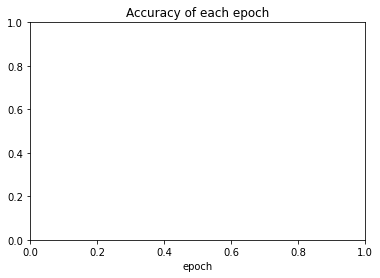

In [118]:
loss_vary = ['validation loss', 'training loss']
loss_set = [val_loss_history, train_loss_history]

draw_result_lines(loss_vary, loss_set, epoch_num=20)

In [119]:
# testing dataset
test = pd.read_csv(TEST_DATA_PATH, sep="\t")
test_dataset = Sequences(test, GloVeEmbedding(return_type='vocab'))

# build data loader
test_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

(20154, 64)
(20156, 64)


AttributeError: 'DataFrame' object has no attribute 'Sentiment'

In [ ]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1)

        for y in test_pred.cpu().numpy():
            predict.append(y)

In [ ]:
ids = test.PhraseId.tolist()
with open('./prediction.csv', 'w') as f:
    f.write('PhraseId,Sentiment\n')
    for i, y in zip(ids,predict):
        f.write('{},{}\n'.format(i, y))